In [17]:
!pip install scikit-learn==1.1.3


Data Types:
 product_id                     object
product_category_name          object
month_year                     object
qty                             int64
total_price                   float64
freight_price                 float64
unit_price                    float64
product_name_lenght             int64
product_description_lenght      int64
product_photos_qty              int64
product_weight_g                int64
product_score                 float64
customers                       int64
weekday                         int64
weekend                         int64
holiday                         int64
month                           int64
year                            int64
s                             float64
volume                          int64
comp_1                        float64
ps1                           float64
fp1                           float64
comp_2                        float64
ps2                           float64
fp2                           float64

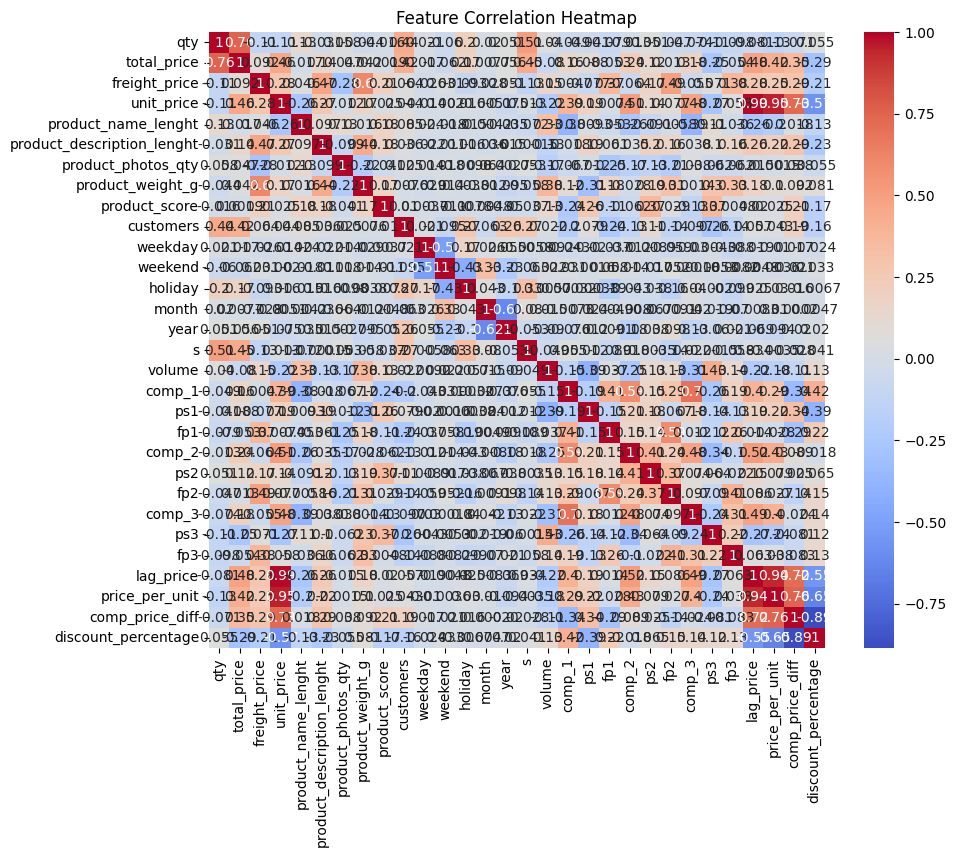

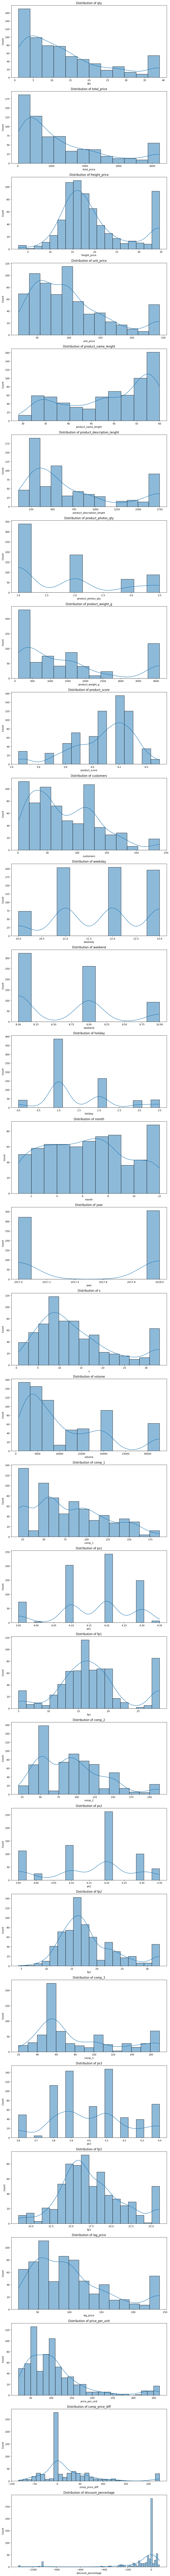


Random Forest:
MSE: 9026.2938
RMSE: 95.0068
MAE: 52.7673
R2: 0.9940
CV_RMSE: 123.1236

Gradient Boosting:
MSE: 4224.5330
RMSE: 64.9964
MAE: 35.2010
R2: 0.9972
CV_RMSE: 104.7988

XGBoost:
MSE: 4778.3099
RMSE: 69.1253
MAE: 42.8662
R2: 0.9968
CV_RMSE: 119.0149


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb


class RetailPriceAnalyzer:
    """
    A class for analyzing retail price data. This class handles data preprocessing,
    feature engineering, model training, evaluation, and visualization.
    """

    def __init__(self, data_path: str) -> None:
        """
        Initialize the analyzer with the path to the CSV data.

        Parameters:
            data_path (str): Path to the CSV file containing the dataset.
        """
        self.data = pd.read_csv(data_path)
        self.models = {}               # Dictionary to store ML models
        self.model_predictions = {}    # Dictionary to store model predictions
        self.model_metrics = {}        # Dictionary to store performance metrics
        self.scaler = StandardScaler() # Scaler for feature standardization

    def preprocess_data(self) -> "RetailPriceAnalyzer":
        """ Preprocess the dataset by performing basic data checks, handling missing values,
        and creating derived features.

        Steps included:
            - Checking data types
            - Describing the dataset
            - Identifying missing values
            - Handling outliers using the IQR method
            - Creating derived features

        Returns:
            self (RetailPriceAnalyzer): Returns the instance to allow method chaining.
        """
        # Display basic dataset information
        print("Data Types:\n", self.data.dtypes)
        print("\nDataset Description:\n", self.data.describe())
        print("\nMissing Values:\n", self.data.isnull().sum())

        # Handle missing values by filling with median values (for numerical features)
        self.data.fillna(self.data.median(numeric_only=True), inplace=True)

        # Identify numeric columns
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns

        # Calculate Q1, Q3, and IQR for outlier detection
        Q1 = self.data[numeric_cols].quantile(0.25)
        Q3 = self.data[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1

        # Determine lower and upper bounds using the IQR method
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Clip values to reduce outlier effects
        self.data[numeric_cols] = self.data[numeric_cols].clip(lower=lower_bound, upper=upper_bound, axis='columns')

        # Create derived features
        self.data['price_per_unit'] = self.data['total_price'] / self.data['qty']
        self.data['comp_price_diff'] = self.data['unit_price'] - self.data['comp_1']
        self.data['discount_percentage'] = ((self.data['comp_1'] - self.data['unit_price']) / self.data['comp_1']) * 100

        return self

    def initialize_models(self) -> None:
        """
        Initialize and store the machine learning models to be compared.

        The following regression models are used:
            - Random Forest Regressor
            - Gradient Boosting Regressor
            - XGBoost Regressor
        """
        self.models = {
            'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
        }

    def prepare_features(self) -> tuple:
        """
        Prepare the feature set and target variable for model training.

        Selected features include both original and derived variables.
        Features are scaled using StandardScaler, and the data is split into
        training and testing sets (80/20 split).

        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        # Define the list of features to be used.
        features = [
            'qty', 'unit_price', 'comp_1', 'product_score',
            'comp_price_diff', 'price_per_unit', 'discount_percentage'
        ]
        X = self.data[features]
        y = self.data['total_price']

        # Scale features for better performance of many machine learning models.
        X_scaled = pd.DataFrame(self.scaler.fit_transform(X), columns=X.columns)

        return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    def train_and_evaluate_models(self, X_train: pd.DataFrame, X_test: pd.DataFrame,
                                  y_train: pd.Series, y_test: pd.Series) -> None:
        """
        Train each model on the training data and evaluate performance on the test data.

        The evaluation metrics include:
            - Mean Squared Error (MSE)
            - Root Mean Squared Error (RMSE)
            - Mean Absolute Error (MAE)
            - R2 Score

        Additionally, 5-fold cross-validation is performed using RMSE as the scoring metric.

        Parameters:
            X_train (pd.DataFrame): Training features.
            X_test (pd.DataFrame): Testing features.
            y_train (pd.Series): Training target.
            y_test (pd.Series): Testing target.
        """
        for name, model in self.models.items():
            # Train the model.
            model.fit(X_train, y_train)
            # Predict on the test set.
            y_pred = model.predict(X_test)
            self.model_predictions[name] = y_pred

            # Calculate performance metrics.
            mse = mean_squared_error(y_test, y_pred)
            self.model_metrics[name] = {
                'mse': mse,
                'rmse': np.sqrt(mse),
                'mae': mean_absolute_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }

            # Perform 5-fold cross-validation (using negative RMSE) and store the average RMSE.
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
            self.model_metrics[name]['cv_rmse'] = -cv_scores.mean()

    def plot_correlation_heatmap(self) -> None:
        """
        Plot a heatmap of the correlation matrix for the numeric features in the dataset.
        """
        plt.figure(figsize=(10, 8))
        numeric_data = self.data.select_dtypes(include=[np.number])
        corr_matrix = numeric_data.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
        plt.title("Feature Correlation Heatmap")
        plt.show()

    def plot_feature_distributions(self) -> None:
        """
        Plot histograms with KDE (Kernel Density Estimate) for each numeric feature
        to visualize their distributions.
        """
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        num_cols = len(numeric_cols)
        # Create subplots: if only one feature, ensure axes is iterable.
        fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5 * num_cols))
        if num_cols == 1:
            axes = [axes]  # Make it iterable if there's only one subplot.

        # Plot each numeric feature.
        for i, col in enumerate(numeric_cols):
            sns.histplot(self.data[col], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()

    def plot_model_comparison(self, y_test: pd.Series) -> list:
        """
        Generate interactive Plotly figures for model performance comparison.

        This method creates:
            - Bar plots for RMSE, MAE, R2, and cross-validation RMSE for each model.
            - A scatter plot comparing predicted vs. actual total_price values for each model.

        Parameters:
            y_test (pd.Series): Actual target values from the test set.

        Returns:
            list: A list of Plotly figure objects.
        """
        # Convert the metrics dictionary into a DataFrame for easier plotting.
        metrics_df = pd.DataFrame([
            {'Model': model, 'Metric': metric, 'Value': value}
            for model, metrics in self.model_metrics.items()
            for metric, value in metrics.items()
        ])

        figs = []
        # Create bar charts for selected performance metrics.
        for metric in ['rmse', 'mae', 'r2', 'cv_rmse']:
            fig = px.bar(
                metrics_df[metrics_df['Metric'] == metric],
                x='Model',
                y='Value',
                title=f'Model Comparison - {metric.upper()}'
            )
            figs.append(fig)

        # Create a scatter plot for Predicted vs. Actual values.
        fig_pred_actual = go.Figure()
        for model_name, y_pred in self.model_predictions.items():
            fig_pred_actual.add_trace(go.Scatter(
                x=y_test,
                y=y_pred,
                mode='markers',
                name=model_name,
                opacity=0.6
            ))
        # Add a reference line for perfect predictions.
        fig_pred_actual.add_trace(go.Scatter(
            x=[y_test.min(), y_test.max()],
            y=[y_test.min(), y_test.max()],
            mode='lines',
            name='Perfect Prediction',
            line=dict(color='black', dash='dash')
        ))
        fig_pred_actual.update_layout(
            title='Predicted vs Actual Values - All Models',
            xaxis_title='Actual Price',
            yaxis_title='Predicted Price'
        )
        figs.append(fig_pred_actual)

        return figs


if __name__ == "__main__":
    # Specify the path to your CSV dataset.
    DATA_PATH = '/content/retail_price.csv'

    # Instantiate the analyzer.
    analyzer = RetailPriceAnalyzer(DATA_PATH)

    # Preprocess data: handle outliers and create derived features.
    analyzer.preprocess_data()

    # Perform exploratory data analysis.
    analyzer.plot_correlation_heatmap()
    analyzer.plot_feature_distributions()

    # Initialize the machine learning models.
    analyzer.initialize_models()

    # Prepare features and split the dataset into training and testing sets.
    X_train, X_test, y_train, y_test = analyzer.prepare_features()

    # Train models and evaluate their performance.
    analyzer.train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Generate comparison plots for model performance.
    comparison_plots = analyzer.plot_model_comparison(y_test)

    # Print out model performance metrics.
    for model_name, metrics in analyzer.model_metrics.items():
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            print(f"{metric.upper()}: {value:.4f}")

    # Display the Plotly comparison plots.
    for fig in comparison_plots:
        fig.show()
